<a href="https://colab.research.google.com/github/nv-hiep/Image_Caption_Generation/blob/main/Image_Caption_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating caption of an image

# Libraries

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import os
import shutil
import glob
import numpy as np
import matplotlib.image as mpimg


# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
import string
import pickle
from tqdm import tqdm
from time import time
from PIL import Image

from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


import tensorflow.keras.preprocessing.image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, TimeDistributed, Dense,
                                     RepeatVector, Activation, Flatten, Reshape,
                                     concatenate, Dropout, BatchNormalization)

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

In [ ]:
START  = 'startseq'
STOP   = 'endseq'
EPOCHS = 10

# Data

In [ ]:
BASE_PATH = '/content/'
DATA_PATH = '/content/data/'
MODEL_DIR = '/content/models/'

In [ ]:
if not os.path.exists(DATA_PATH):
  os.mkdir(DATA_PATH)

In [ ]:
if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

In [ ]:
def tree_printer(root):
  for root, dirs, files in os.walk(root):
    for d in dirs:
      print( os.path.join(root, d) )
    # for f in files:
    #   print(os.path.join(root, f))
tree_printer('/content/')

/content/.config
/content/data
/content/models
/content/sample_data
/content/.config/logs
/content/.config/configurations
/content/.config/logs/2021.06.01


In [ ]:
def download_and_unzip(url, extract_to='.'):
  http_response = urlopen(url)
  zipfile = ZipFile(BytesIO(http_response.read()))
  zipfile.extractall(path=extract_to)

## Download Flickr8k_Dataset

Dataset (images)

In [ ]:
flickr8k_dataset_url = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'
download_and_unzip(flickr8k_dataset_url, extract_to=DATA_PATH)

Caption text

In [ ]:
flickr8k_text_url = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip'
download_and_unzip(flickr8k_text_url, extract_to=DATA_PATH)

## Download Glove 6B

Vector representations for words

In [ ]:
glove6B_url = 'https://nlp.stanford.edu/data/glove.6B.zip'
download_and_unzip(glove6B_url, extract_to=DATA_PATH)

# Clean data

In [ ]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = {}

with open( os.path.join(DATA_PATH, 'Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id      = tok[0].split('.')[0]
      caption = tok[1:]
      
      # Cleanup caption
      caption = [word.lower() for word in caption]
      caption = [w.translate(null_punct) for w in caption]
      caption = [word for word in caption if len(word)>1]
      caption = [word for word in caption if word.isalpha()]
      max_length = max(max_length, len(caption))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(caption))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]

In [ ]:
# Format time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f'{h}:{m:>02}:{s:>05.2f}'

In [ ]:
lookup['2095444126_201ff9f222']

['dog is shaking off water',
 'dog shakes his head',
 'dog shakes off water',
 'dog shakes off water and gets contorted',
 'the dog is shaking water off of his body']

In [ ]:
lex

{'lapse',
 'safari',
 'go',
 'game',
 'cheek',
 'dot',
 'bounce',
 'ladys',
 'fishemen',
 'his',
 'saltandpepperhaired',
 'kickboxer',
 'guide',
 'grocery',
 'ridge',
 'sheepdogs',
 'cartwheel',
 'bulls',
 'bodyboard',
 'stucco',
 'gliding',
 'picure',
 'mule',
 'lunch',
 'conversations',
 'waded',
 'swimming',
 'burns',
 'nibbles',
 'crystal',
 'carpeting',
 'mussels',
 'chickens',
 'passengers',
 'ornamental',
 'teeter',
 'poppies',
 'can',
 'wagging',
 'chip',
 'bordering',
 'htting',
 'instrument',
 'sides',
 'winston',
 'wicket',
 'dressed',
 'sorts',
 'waterskiing',
 'flakes',
 'shepherd',
 'accelerates',
 'near',
 'avoids',
 'chinese',
 'waterfall',
 'creamy',
 'leatherclad',
 'dips',
 'parka',
 'zoo',
 'easy',
 'burgers',
 'la',
 'beack',
 'pitcher',
 'skies',
 'amplifier',
 'calculate',
 'dumped',
 'enviorment',
 'bookcase',
 'logos',
 'raincoat',
 'pavement',
 'frowning',
 'evil',
 'jumper',
 'takeout',
 'dragons',
 'swam',
 'information',
 'clothes',
 'duck',
 'anklehigh',
 

In [ ]:
print('Number of images: ', len(lookup))       # lookup - dict - image_id : [captions]
print('Number of unique words: ', len(lex))    # Number of unique words
print(max_length)                              # Maximum length of a caption (in words)

8092
8763
32


In [ ]:
# Warning, running this too soon on GDrive can sometimes not work.
# Just rerun if len(img) = 0
img = glob.glob(os.path.join(DATA_PATH, 'Flicker8k_Dataset', '*.jpg'))

In [ ]:
len(img)

8091

In [ ]:
img[:5]

['/content/data/Flicker8k_Dataset/2497074804_b4f3e7fd90.jpg',
 '/content/data/Flicker8k_Dataset/3718007650_e5930b4509.jpg',
 '/content/data/Flicker8k_Dataset/2559638792_a803ff63d1.jpg',
 '/content/data/Flicker8k_Dataset/109202801_c6381eef15.jpg',
 '/content/data/Flicker8k_Dataset/2894850774_2d530040a1.jpg']

Read all image names and use the predefined train/test sets.

In [ ]:
train_images_path = os.path.join(DATA_PATH,'Flickr_8k.trainImages.txt') 
train_images      = set( open(train_images_path, 'r').read().strip().split('\n') )

test_images_path = os.path.join(DATA_PATH, 'Flickr_8k.testImages.txt') 
test_images      = set( open(test_images_path, 'r').read().strip().split('\n') )

In [ ]:
num_train = len(train_images)
print('Number of images for training: ', num_train )

#
#{'1148238960_f8cacec2fc.jpg',
# '241345596_91e0e2daf5.jpg',
# '181777261_84c48b31cb.jpg', ... }
#

Number of images for training:  6000


In [ ]:
num_test = len(test_images)
print('Number of images for training: ', num_test )

Number of images for training:  1000


In [ ]:
train_img = []
test_img = []
for i in img:
  # Use the tail (no slash / )
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f)

In [ ]:
num_train = len(train_img)
print('Number of images for training: ', num_train )
train_img[:5]

Number of images for training:  6000


['2497074804_b4f3e7fd90.jpg',
 '3718007650_e5930b4509.jpg',
 '2559638792_a803ff63d1.jpg',
 '109202801_c6381eef15.jpg',
 '2894850774_2d530040a1.jpg']

In [ ]:
num_test = len(test_img)
print('Number of images for training: ', num_test )
test_img[:3]

Number of images for training:  1000


['3655155990_b0e201dd3c.jpg',
 '2472980433_210ec62874.jpg',
 '2718024196_3ff660416a.jpg']

Build the sequences. We include a start and stop token at the beginning/end. We will later use the start token to begin the process of generating a caption. Encountering the stop token in the generated text will let us know the process is complete.

In [ ]:
train_captions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_captions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [ ]:
train_captions['2257099774_37d0d3aa9a']

['startseq an elderly asian woman wearing blue winter coat and red hat in front of food counter endseq',
 'startseq woman in red cap in store endseq',
 'startseq woman wearing red hat and black coat endseq',
 'startseq woman with red hat and face stands in front of jars endseq',
 'startseq the hapy asian woman is at the market endseq']

In [ ]:
len(train_captions)

6000

# InceptionV3 Network

In [ ]:
# The input size and output of the InceptionV3 network
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048

encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Creating the Training Set

We need to encode the images to create the training set. Later we will encode new images to present them for captioning.

In [ ]:
def encode_image(img):
  # Resize all images to the size specified by the network
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  
  # Convert image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  
  # Perform any preprocessing needed by InceptionV3
  x = preprocess_input(x)
  
  # Call InceptionV3 to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  
  return x

In [ ]:
training_path = os.path.join( DATA_PATH, 'train')
if not os.path.exists(training_path):
  os.mkdir(training_path)

In [ ]:
test_path = os.path.join( DATA_PATH, 'test')
if not os.path.exists(test_path):
  os.mkdir(test_path)

In [ ]:
train_path = os.path.join(training_path, f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(DATA_PATH, 'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encode_image(img)
  with open(train_path, 'wb') as fp:
    pickle.dump(encoding_train, fp)
  print(f'\n Generating training set took: {hms_string(time()-start)}')
else:
  with open(train_path, 'rb') as fp:
    encoding_train = pickle.load(fp)

100%|██████████| 6000/6000 [06:45<00:00, 14.80it/s]



Generating training set took: 0:06:45.47


In [ ]:
test_path = os.path.join(test_path, f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(DATA_PATH, 'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encode_image(img)
  with open(test_path, 'wb') as fp:
    pickle.dump(encoding_test, fp)
  print(f'\nGenerating testing set took: {hms_string(time()-start)}')
else:
  with open(test_path, 'rb') as fp:
    encoding_test = pickle.load(fp)

100%|██████████| 1000/1000 [01:03<00:00, 15.72it/s]


Generating testing set took: 0:01:03.63


Next, we separate the captions that we will use for training. There are two sides to this training, the images, and the captions.

In [ ]:
all_train_captions = []
for key, val in train_captions.items():
  # image_id : [captions]
  for cap in val:
    all_train_captions.append(cap)
len(all_train_captions)

30000

Words that do not occur very often can be misleading to neural network training. Remove any words that occur less than 10 times. The new size of the vocabulary shrunk.

In [ ]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
  nsents += 1
  for w in sent.split(' '):
    word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('Preprocessed words: %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


Next, we build two lookup tables for this vocabulary. The table idxtoword converts index numbers to actual words to index values. The wordtoidx lookup table performs the opposite.

In [ ]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
  wordtoidx[w] = ix
  idxtoword[ix] = w
  ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652


Previously we added a start and stop token to all sentences. We must account for this in the maximum length of captions.

In [ ]:
max_length +=2
print(max_length)

34


# Create a Data Generator

Up to this point, we've always generated training data ahead of time and fit the neural network to it. It is not always practical to create all of the training data ahead of time. The memory demands can be considerable. If we generate the training data as the neural network needs it, it is possible to use a Keras generator. The generator will create new data as it is needed. The generator provided here creates the training data for the caption neural network, as it is needed.

In [ ]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n = 0
  while True:
    for key, desc_list in descriptions.items():
      n += 1
      photo = photos[key + '.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if (n == num_photos_per_batch):
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n = 0

# Loading Glove Embeddings

In [ ]:
f = open(os.path.join(DATA_PATH, 'glove.6B.200d.txt'), encoding='utf-8')

# embeddings_index is a dict - word:[vector of float numbers]
# e.g
# embeddings_index['and'] = array([ 2.0327e-01, ...])
# with the vector length = 200
embeddings_index = {}
for line in tqdm(f):
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:17, 22733.44it/s]

Found 400000 word vectors.


In [ ]:
print( embeddings_index['the'].shape )
print( embeddings_index['the'] )

(200,)
[-7.1549e-02  9.3459e-02  2.3738e-02 -9.0339e-02  5.6123e-02  3.2547e-01
 -3.9796e-01 -9.2139e-02  6.1181e-02 -1.8950e-01  1.3061e-01  1.4349e-01
  1.1479e-02  3.8158e-01  5.4030e-01 -1.4088e-01  2.4315e-01  2.3036e-01
 -5.5339e-01  4.8154e-02  4.5662e-01  3.2338e+00  2.0199e-02  4.9019e-02
 -1.4132e-02  7.6017e-02 -1.1527e-01  2.0060e-01 -7.7657e-02  2.4328e-01
  1.6368e-01 -3.4118e-01 -6.6070e-02  1.0152e-01  3.8232e-02 -1.7668e-01
 -8.8153e-01 -3.3895e-01 -3.5481e-02 -5.5095e-01 -1.6899e-02 -4.3982e-01
  3.9004e-02  4.0447e-01 -2.5880e-01  6.4594e-01  2.6641e-01  2.8009e-01
 -2.4625e-02  6.3302e-01 -3.1700e-01  1.0271e-01  3.0886e-01  9.7792e-02
 -3.8227e-01  8.6552e-02  4.7075e-02  2.3511e-01 -3.2127e-01 -2.8538e-01
  1.6670e-01 -4.9707e-03 -6.2714e-01 -2.4904e-01  2.9713e-01  1.4379e-01
 -1.2325e-01 -5.8178e-02 -1.0290e-03 -8.2126e-02  3.6935e-01 -5.8442e-04
  3.4286e-01  2.8426e-01 -6.8599e-02  6.5747e-01 -2.9087e-02  1.6184e-01
  7.3672e-02 -3.0343e-01  9.5733e-02 -5.2860

In [ ]:
embeddings_index['and']

array([ 2.0327e-01,  4.7348e-01,  5.0877e-02,  2.1030e-03,  6.0547e-02,
        3.3066e-01,  4.8486e-02,  2.1504e-02, -5.3631e-01,  2.1312e-01,
        1.9983e-01,  5.1408e-01,  7.0422e-04,  9.4641e-02,  6.8724e-02,
        2.7424e-01, -2.0493e-01,  2.3268e-01,  3.2490e-01, -1.9444e-01,
        6.4693e-01,  2.8342e+00,  1.4004e-01, -2.6868e-01,  2.7325e-01,
        1.5312e-02, -2.7975e-01, -2.6423e-01,  1.4183e-01, -2.6064e-02,
        1.1349e-01,  2.5039e-01, -2.4972e-01, -1.6882e-01, -3.1039e-01,
       -4.4458e-01, -3.4789e-01, -2.0181e-01, -1.3405e-02,  2.3635e-01,
        1.7741e-01, -1.0535e-01, -2.0716e-01,  3.7856e-01,  1.0507e-01,
       -3.0970e-01,  4.6782e-01, -5.0021e-01,  2.6643e-01,  5.1564e-01,
        5.4247e-02,  5.0546e-01, -2.4959e-01,  5.4021e-01,  1.7268e-01,
       -3.8650e-02,  2.3730e-02,  2.4111e-01,  1.7210e-01,  7.8734e-02,
        3.1275e-01,  1.8700e-01, -4.5933e-01,  5.5853e-01,  2.2511e-01,
        1.6761e-01, -4.5662e-02,  5.5918e-01, -2.4065e-01, -2.49

In [ ]:
embeddings_index['and'].shape

(200,)

# Building the Neural Network

We build an embedding matrix from Glove. We will directly copy this matrix to the weight matrix of the neural network.

In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
  #if i < max_words:
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # Words not found in the embedding index will be all zeros
    embedding_matrix[i] = embedding_vector


The matrix dimensions make sense. It is 1652 (the size of the vocabulary) by 200 (the number of features Glove generates for each word).

In [ ]:
embedding_matrix.shape

(1652, 200)

## Network

In [ ]:
inputs1 = Input(shape=(OUTPUT_DIM,))
x1 = Dropout(0.5)(inputs1)
x1 = Dense(256, activation='relu')(x1)

inputs2 = Input(shape=(max_length,))
x2 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
x2 = Dropout(0.5)(x2)
x2 = LSTM(256)(x2)

decoder = add([x1, x2])
decoder = Dense(256, activation='relu')(decoder)

outputs = Dense(vocab_size, activation='softmax')(decoder)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

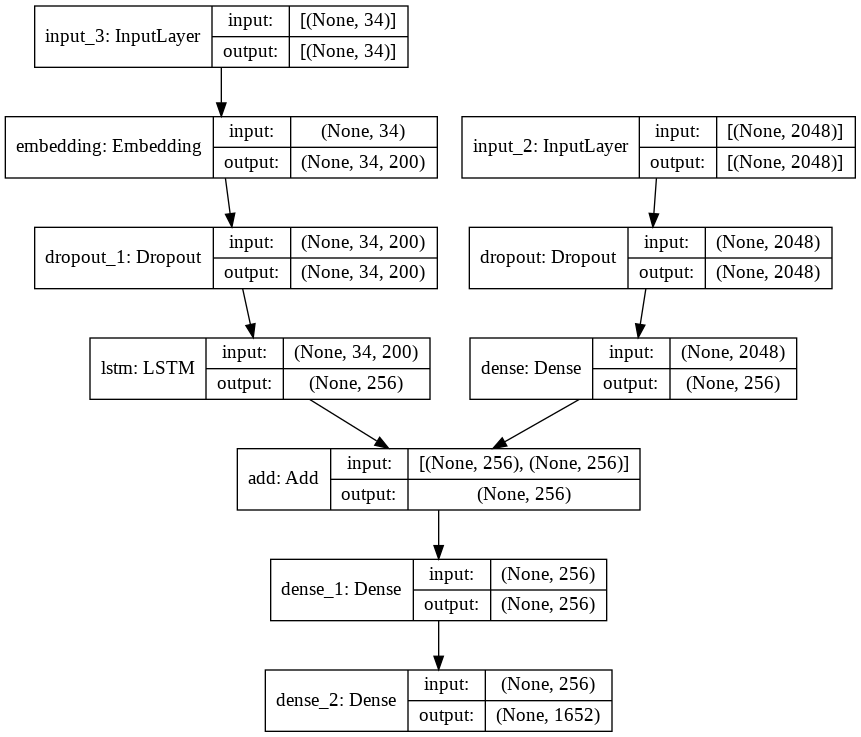

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(caption_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Train the Neural Network

In [ ]:
number_pics_per_batch = 3
steps = len(train_captions)//number_pics_per_batch

In [ ]:
model_path = os.path.join(MODEL_DIR, f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_captions, encoding_train, wordtoidx, max_length, number_pics_per_batch)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_batch = 6
  steps = len(train_captions)//number_pics_per_batch

  for i in range(EPOCHS):
      generator = data_generator(train_captions, encoding_train, wordtoidx, max_length, number_pics_per_batch)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")

else:
  caption_model.load_weights(model_path)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2000/2000 [==============================] - 174s 85ms/step - loss: 4.1186


  5%|▌         | 1/20 [02:54<55:12, 174.36s/it]

2000/2000 [==============================] - 173s 86ms/step - loss: 3.4223


 10%|█         | 2/20 [06:16<54:47, 182.63s/it]

2000/2000 [==============================] - 172s 86ms/step - loss: 3.2079


 15%|█▌        | 3/20 [09:38<53:23, 188.42s/it]

2000/2000 [==============================] - 172s 86ms/step - loss: 3.0760


 20%|██        | 4/20 [12:29<48:54, 183.40s/it]

2000/2000 [==============================] - 170s 85ms/step - loss: 2.9796


 25%|██▌       | 5/20 [15:19<44:48, 179.25s/it]

2000/2000 [==============================] - 170s 85ms/step - loss: 2.9053


 30%|███       | 6/20 [18:09<41:09, 176.39s/it]

2000/2000 [==============================] - 171s 85ms/step - loss: 2.8475


 35%|███▌      | 7/20 [21:00<37:51, 174.75s/it]

2000/2000 [==============================] - 170s 85ms/step - loss: 2.7985


 40%|████      | 8/20 [23:50<34:41, 173.47s/it]

2000/2000 [==============================] - 170s 85ms/step - loss: 2.7585


 45%|████▌     | 9/20 [27:12<33:22, 182.01s/it]

2000/2000 [==============================] - 170s 85ms/step - loss: 2.7195


 50%|█████     | 10/20 [30:34<31:19, 187.99s/it]

2000/2000 [==============================] - 170s 85ms/step - loss: 2.6888


 55%|█████▌    | 11/20 [33:24<27:24, 182.71s/it]

2000/2000 [==============================] - 171s 85ms/step - loss: 2.6635


 60%|██████    | 12/20 [36:15<23:52, 179.07s/it]

2000/2000 [==============================] - 172s 86ms/step - loss: 2.6409


 65%|██████▌   | 13/20 [39:07<20:38, 176.91s/it]

2000/2000 [==============================] - 172s 86ms/step - loss: 2.6191


 70%|███████   | 14/20 [41:59<17:33, 175.52s/it]

2000/2000 [==============================] - 173s 86ms/step - loss: 2.6011


 75%|███████▌  | 15/20 [44:52<14:33, 174.71s/it]

2000/2000 [==============================] - 171s 85ms/step - loss: 2.5808


 80%|████████  | 16/20 [47:43<11:34, 173.55s/it]

2000/2000 [==============================] - 170s 85ms/step - loss: 2.5672


 85%|████████▌ | 17/20 [50:33<08:37, 172.47s/it]

2000/2000 [==============================] - 174s 87ms/step - loss: 2.5540


 90%|█████████ | 18/20 [53:55<06:02, 181.31s/it]

2000/2000 [==============================] - 176s 88ms/step - loss: 2.5382


 95%|█████████▌| 19/20 [56:50<02:59, 179.63s/it]

2000/2000 [==============================] - 174s 87ms/step - loss: 2.5288


100%|██████████| 20/20 [1:00:12<00:00, 180.64s/it]

   1/1000 [..............................] - ETA: 1:47 - loss: 2.5796

1000/1000 [==============================] - 94s 94ms/step - loss: 2.3691
\Training took: 1:29:10.24


# Prediction: Generating Captions

It is essential to understand that we do not generate a caption with one single call to the neural network's predict function. Neural networks output a fixed-length tensor. To get a variable-length output, such as free-form text, requires multiple calls to the neural network.

The neural network accepts two objects (which we map to the input neurons). The first input is the photo, and the second input is an ever-growing caption. The caption begins with just the starting token. The neural network's output is the prediction of the next word in the caption. The caption continues to grow until the neural network predicts an end token, or we reach the maximum length of a caption.

In [ ]:
def generate_caption(photo):
  in_text = START
  for i in range(max_length):
    sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
    sequence = pad_sequences([sequence], maxlen=max_length)
    
    yhat = caption_model.predict([photo,sequence], verbose=0)
    yhat = np.argmax(yhat)
    word = idxtoword[yhat]
    in_text += ' ' + word
    if word == STOP:
      break
  
  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  
  return final

# Evaluate Performance on Test Data from Flicker8k

The caption model performs relatively well on images that are similar to the training set.

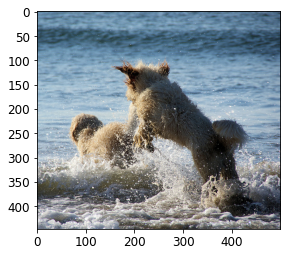

/content/data/Flicker8k_Dataset/3655155990_b0e201dd3c.jpg
Caption:  white dog is running through the water




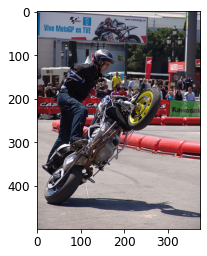

/content/data/Flicker8k_Dataset/2472980433_210ec62874.jpg
Caption:  man in blue shirt rides his bike on the street




In [ ]:
num_pics = 2
for i in range(num_pics): # set higher to see more examples
  pic = list(encoding_test.keys())[i]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))


  x = plt.imread(os.path.join(DATA_PATH, 'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  
  print(os.path.join(DATA_PATH, 'Flicker8k_Dataset', pic))
  print('Caption: ', generate_caption(image))
  print('')
  print()

In [ ]:
encoding_test[pic].shape

(2048,)

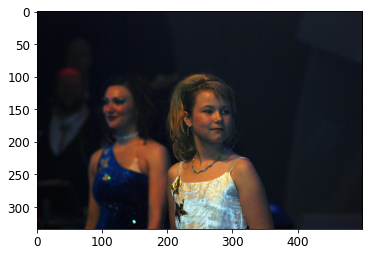

/content/data/Flicker8k_Dataset/2396691909_6b8c2f7c44.jpg
Caption:  two women in black tops are standing in front of crowd




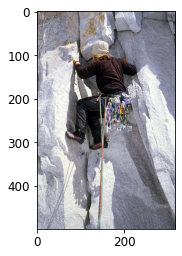

/content/data/Flicker8k_Dataset/486917990_72bd4069af.jpg
Caption:  man in red shirt is standing on the sidewalk




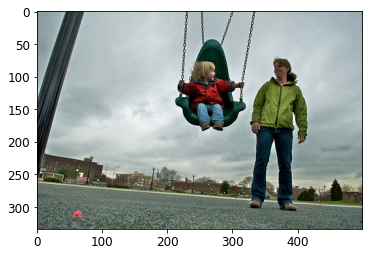

/content/data/Flicker8k_Dataset/3399284917_721aefe2a7.jpg
Caption:  boy in blue shirt is swinging on swing set




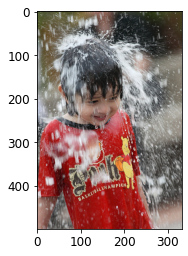

/content/data/Flicker8k_Dataset/3208074567_ac44aeb3f3.jpg
Caption:  boy in blue shorts is splashing in the water




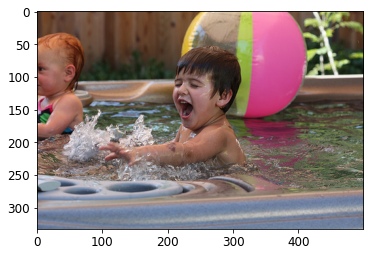

/content/data/Flicker8k_Dataset/3605676864_0fb491267e.jpg
Caption:  boy is splashing in the water




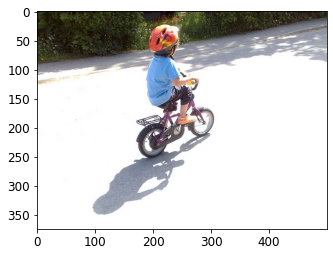

/content/data/Flicker8k_Dataset/2544182005_3aa1332bf9.jpg
Caption:  man in blue shirt is riding his bike on the sidewalk




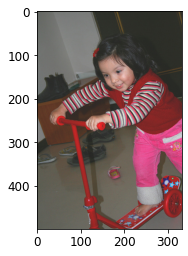

/content/data/Flicker8k_Dataset/2197275664_fabcf3424b.jpg
Caption:  young boy wearing red shirt is jumping off of yellow slide




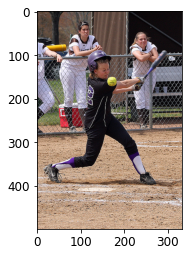

/content/data/Flicker8k_Dataset/3484832904_08619300d9.jpg
Caption:  boy in baseball game




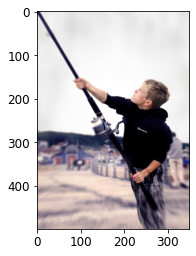

/content/data/Flicker8k_Dataset/2797149878_bb8e27ecf9.jpg
Caption:  boy in red shirt is jumping on trampoline




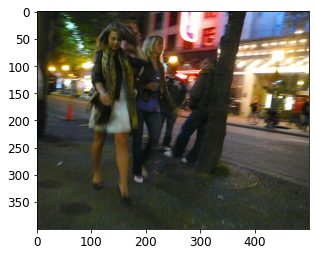

/content/data/Flicker8k_Dataset/2715035273_8fc8b1291c.jpg
Caption:  man in black coat and hat is standing in front of an intersection




In [ ]:
num_pics = 10
for i in range(num_pics): # set higher to see more examples
  pic = list(encoding_test.keys())[10+i]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))


  x = plt.imread(os.path.join(DATA_PATH, 'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  
  print(os.path.join(DATA_PATH, 'Flicker8k_Dataset', pic))
  print('Caption: ', generate_caption(image))
  print('')
  print()